In [1]:
import json
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import keras
from numpy import array
from keras.utils import plot_model
import neurokit2 as nk
import tensorflow as tf
from skimage.restoration import denoise_wavelet
from sklearn.preprocessing import StandardScaler

# Read data from CSV files

In [2]:
def read_csv(filepath):
    f = open(filepath)
    data = json.load(f)
    return data

#ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.txt')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.txt')

# Remove first and last few minutes of data for cleaning and split it into segments of 10 seconds

In [3]:
#remove first and last few minutes
for patient in ecg_filt:
    ecg_filt[patient] = ecg_filt[patient][5000:700000]
    #ecg[patient] = ecg[patient][5000:763000]

    ecg_filt[patient] = nk.ecg_clean(ecg_filt[patient], sampling_rate=62.475)

In [4]:
duration = int(10*62.4725)
segments_ecg = []

for patient in ecg_filt:
    values = ecg_filt[patient]
    for i in range(0,len(values) - duration + 1, duration):
        segments_ecg.append(values[i : (i + duration)])

# Find quality of each segment
 Assess the quality of the ECG Signal by extracting several signal quality indexes (SQIs): QRS wave power spectrum distribution pSQI, kurtosis kSQI, and baseline relative power basSQI.  It returns a vector containing the quality index classification (Unacceptable, Barely Acceptable or Excellent) of the signal.
 We remove the Invalid signals from our datatset for training the autoencoder

In [5]:
quality = []
for i in range(len(segments_ecg)):
    try:
        quality.append(nk.ecg_quality(segments_ecg[i],
                   sampling_rate = 62.475,
                   method="zhao2018",
                   approach="simple"))
    except:
        quality.append("Invalid Input")

In [6]:
indices = np.where(np.array(quality) != "Invalid Input")[0]

normal_ecg = [segments_ecg[x] for x in indices]

# Split the data into Train test and validation sets
- Train set: 60%
- Test set: 20%
- Validation set: 20%

In [7]:
train_df, val_df = train_test_split(normal_ecg,test_size=0.4,shuffle = True)
test_df, val_df = train_test_split(val_df,test_size=0.5,shuffle = True)

train_df = np.stack(train_df)
val_df = np.stack(val_df)
test_df = np.stack(test_df)

x_train = train_df.reshape(train_df.shape[0],train_df.shape[1], 1)
x_val = val_df.reshape(val_df.shape[0],val_df.shape[1], 1)
x_test = val_df.reshape(test_df.shape[0],test_df.shape[1], 1)

print("Training input shape: ", x_train.shape)
print("Val input shape: ", x_val.shape)
print("Test input shape: ", x_test.shape)

Training input shape:  (11078, 624, 1)
Val input shape:  (3693, 624, 1)
Test input shape:  (3693, 624, 1)


# Define the Autoencoder model

In [31]:
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.regularizers import l2

class detector(Model):
    def __init__(self):
        super(detector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(filters=64, kernel_size=5, padding="same", strides=1, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Conv1D(filters=32, kernel_size=5, padding="same", strides=1, activation="relu",kernel_regularizer=l2(0.01)),
            layers.Conv1D(filters=16, kernel_size=5, padding="same", strides=1, activation="relu",kernel_regularizer=l2(0.01))
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv1D(filters=16, kernel_size=5, padding="same", strides=1, activation="relu",kernel_regularizer=l2(0.01)),
            layers.Conv1D(filters=32, kernel_size=5, padding="same", strides=1, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Conv1D(filters=1, kernel_size=5, padding="same")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [32]:
#Let's compile and train the model!!
autoencoder = detector()
autoencoder.compile(optimizer="adam", loss="mse")

# Train the model

In [33]:
history = autoencoder.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, x_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

Epoch 1/10
87/87 [==============================] - 22s 230ms/step - loss: 0.4924 - val_loss: 0.1725
Epoch 2/10
87/87 [==============================] - 20s 232ms/step - loss: 0.0965 - val_loss: 0.0572
Epoch 3/10
87/87 [==============================] - 20s 231ms/step - loss: 0.0471 - val_loss: 0.0403
Epoch 4/10
87/87 [==============================] - 19s 223ms/step - loss: 0.0346 - val_loss: 0.0343
Epoch 5/10
87/87 [==============================] - 20s 231ms/step - loss: 0.0314 - val_loss: 0.0300
Epoch 6/10
87/87 [==============================] - 19s 219ms/step - loss: 0.0287 - val_loss: 0.0281
Epoch 7/10
87/87 [==============================] - 20s 233ms/step - loss: 0.0275 - val_loss: 0.0266
Epoch 8/10
87/87 [==============================] - 21s 240ms/step - loss: 0.0268 - val_loss: 0.0261
Epoch 9/10
87/87 [==============================] - 21s 243ms/step - loss: 0.0307 - val_loss: 0.0295
Epoch 10/10
87/87 [==============================] - 19s 220ms/step - loss: 0.0264 - val_lo

# Check the model
#### The model is checked first on the training data to see if it is learning the waveform correctly.

4/4 [==============================] - 0s 19ms/step


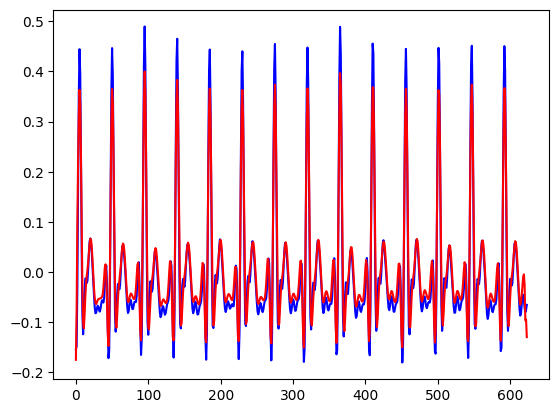

In [42]:
x_train_pred = autoencoder.predict(x_train[0:100])

plt.plot(x_train[0], color="blue")
plt.plot(x_train_pred[0], color="red")
plt.show()

# Test the model
#### The model is tested on the test data.

The histogram showing the reconstruction losses is plotted. Segments with high reconstruction loss are deemed to be very different from the learned pattern and hence classified as anomalies

116/116 [==============================] - 2s 15ms/step


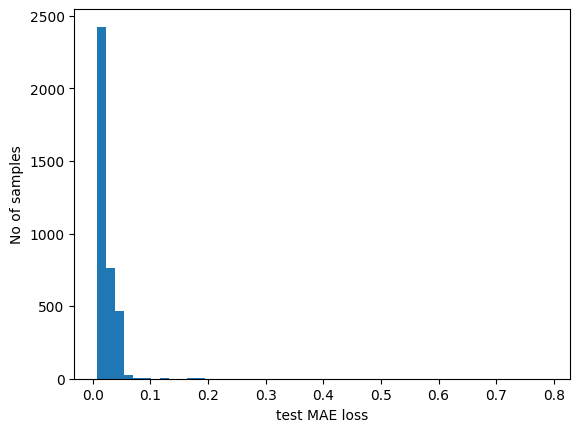

In [37]:
x_test_pred = autoencoder.predict(x_test)

# Get test MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
x_test_pred.shape
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()


# Plot anomalous segments

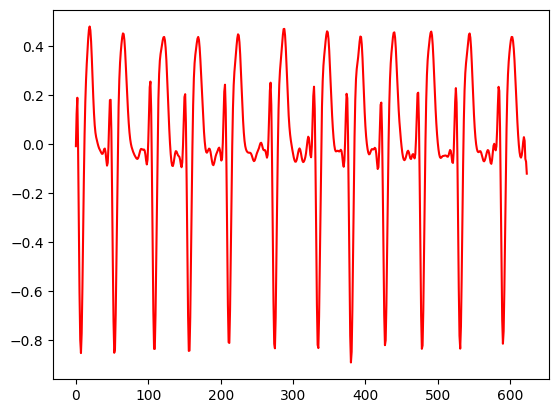

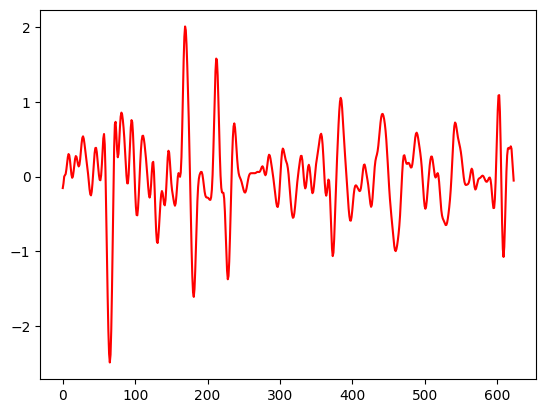

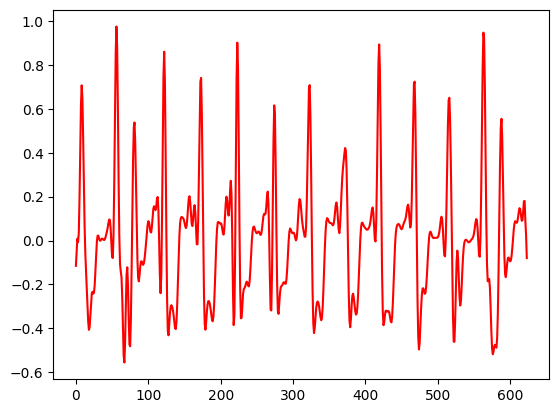

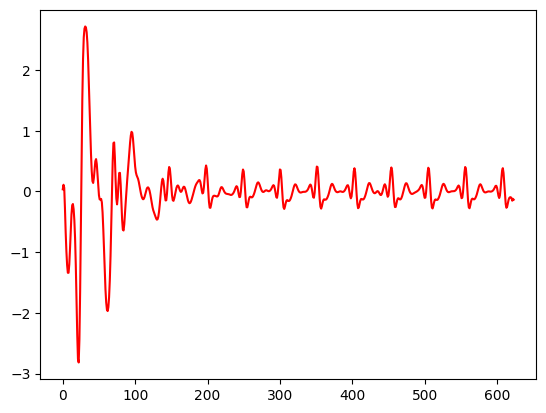

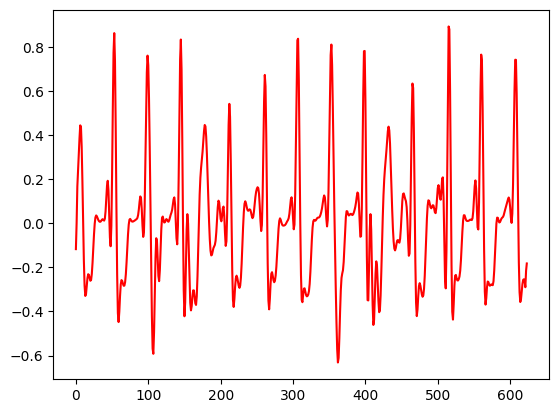

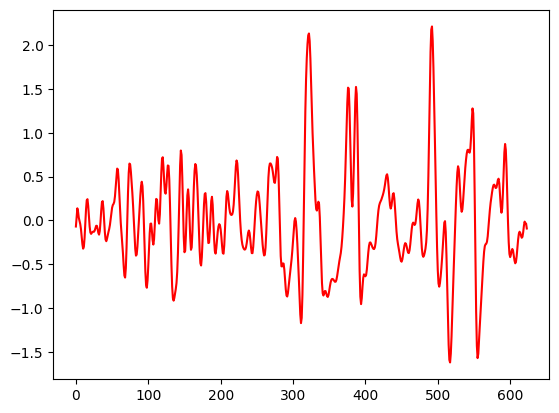

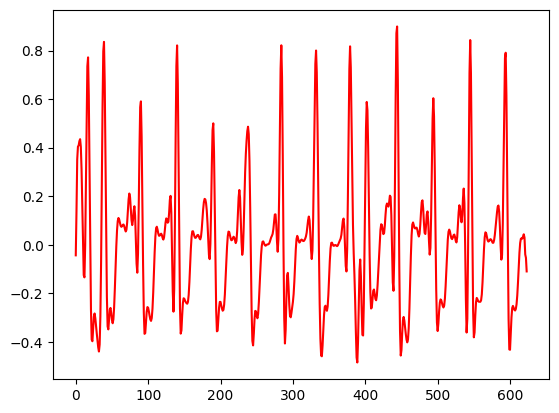

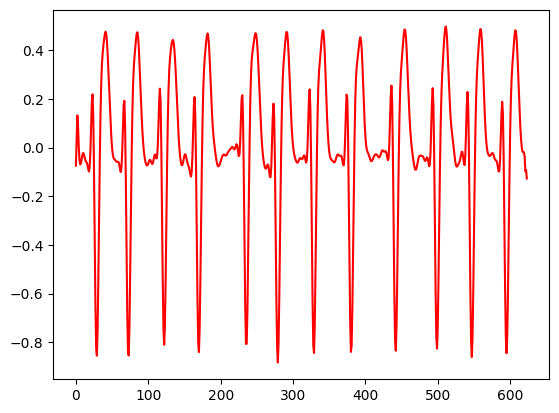

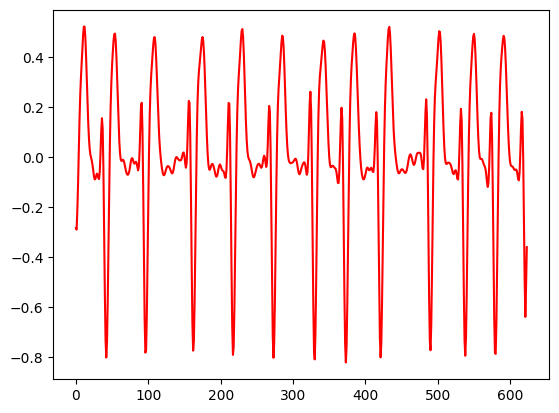

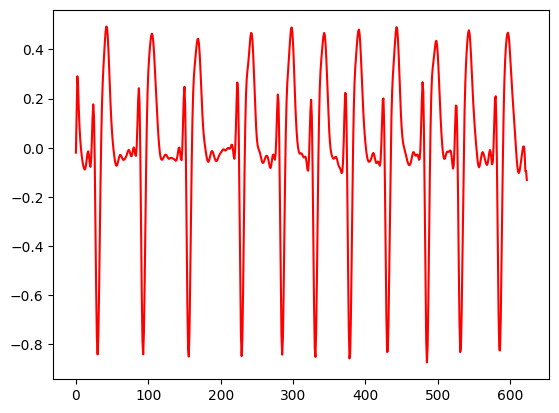

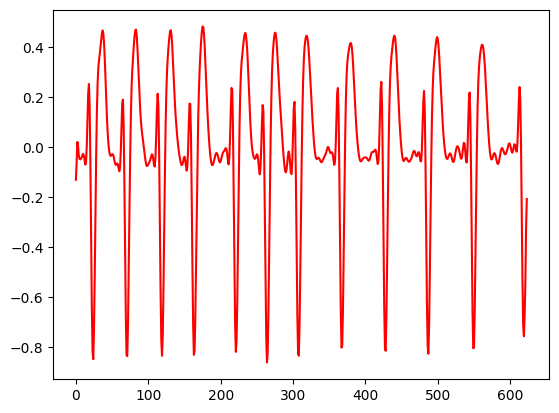

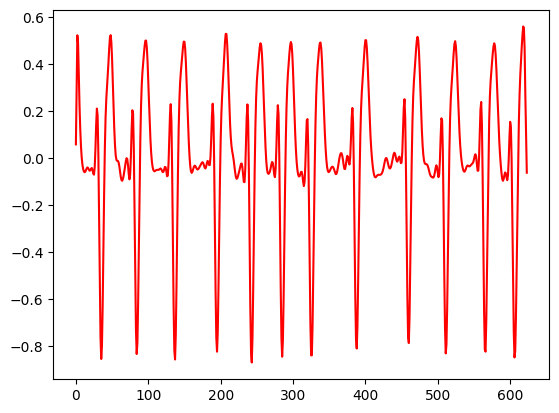

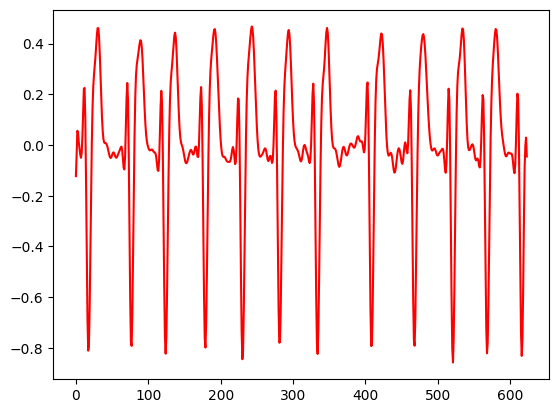

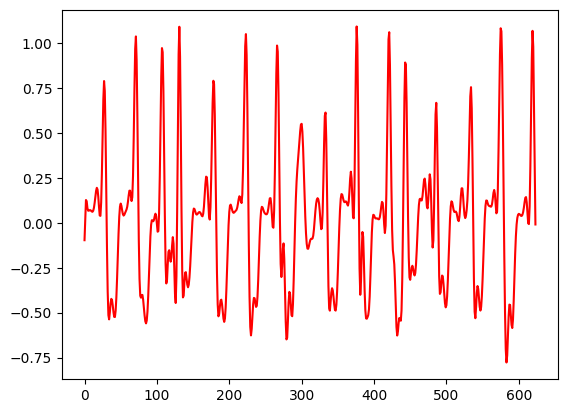

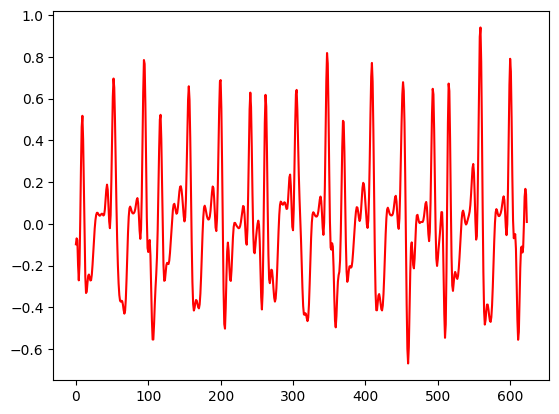

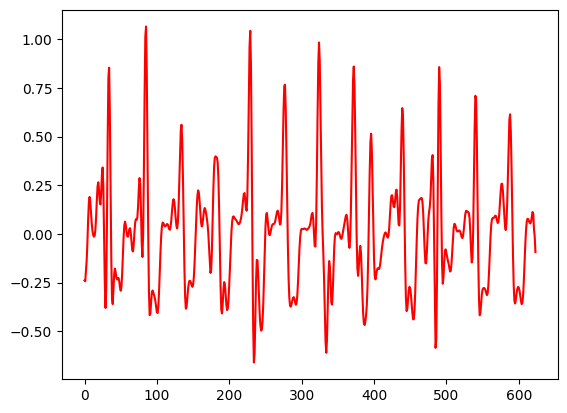

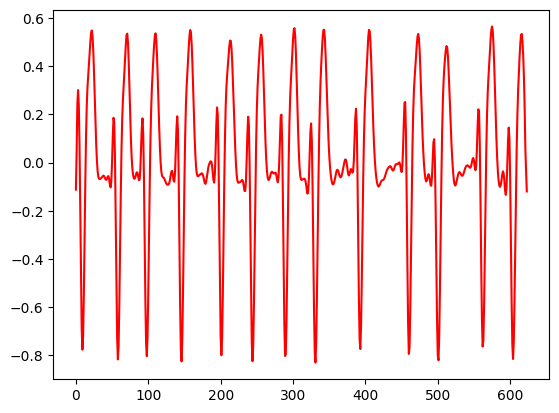

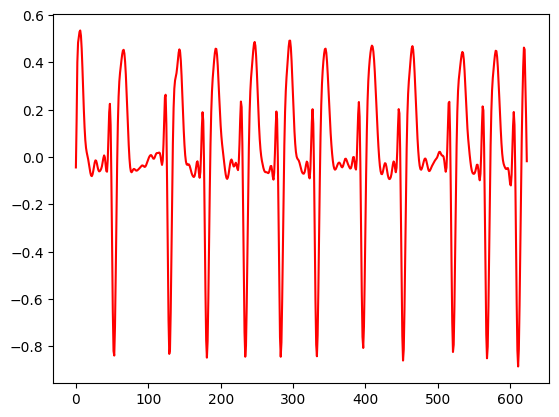

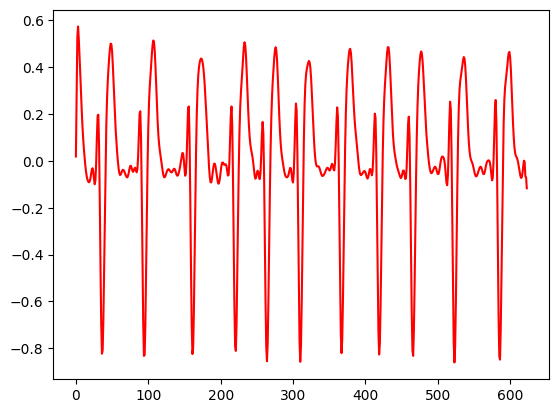

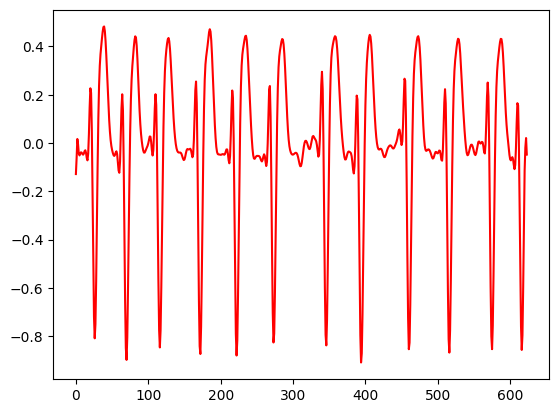

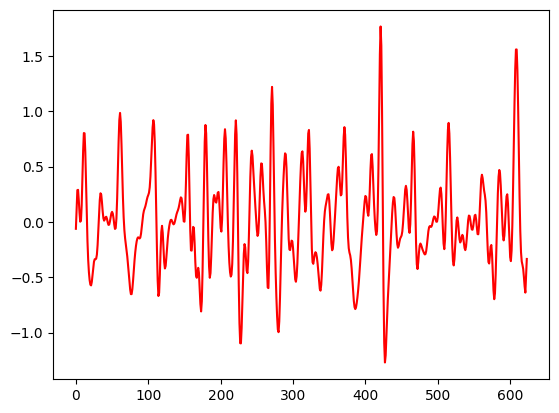

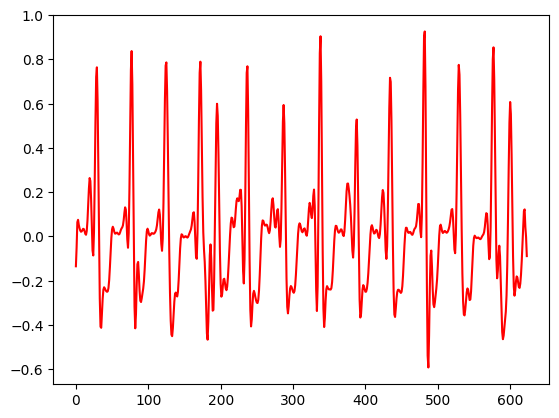

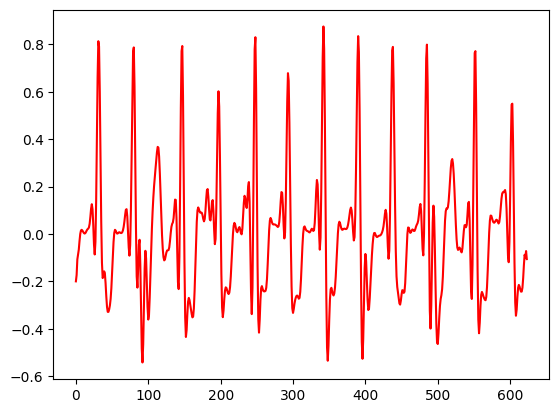

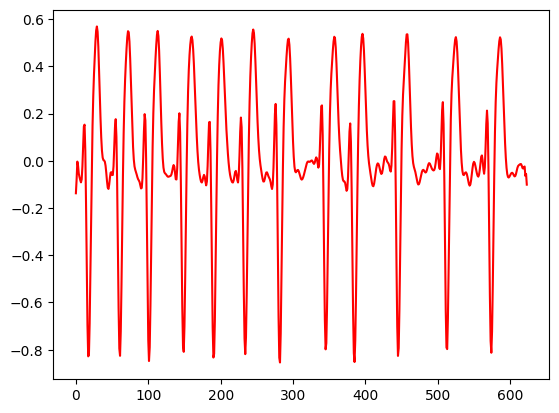

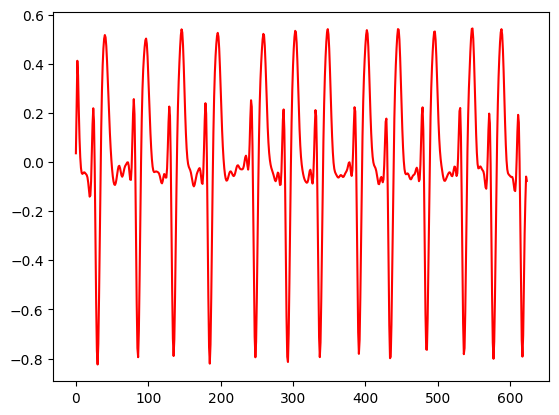

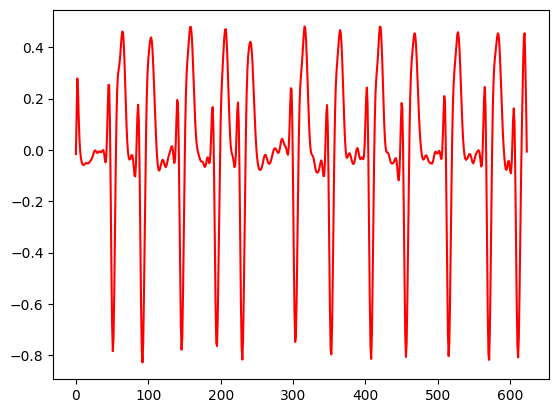

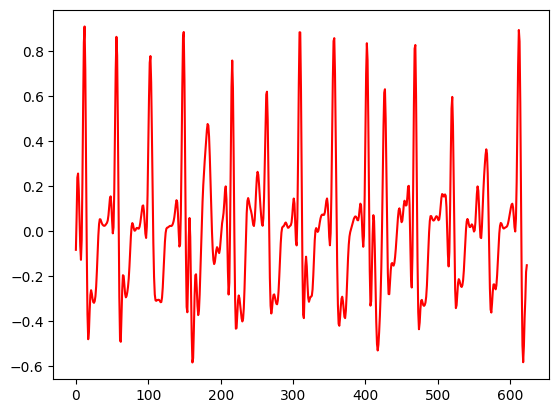

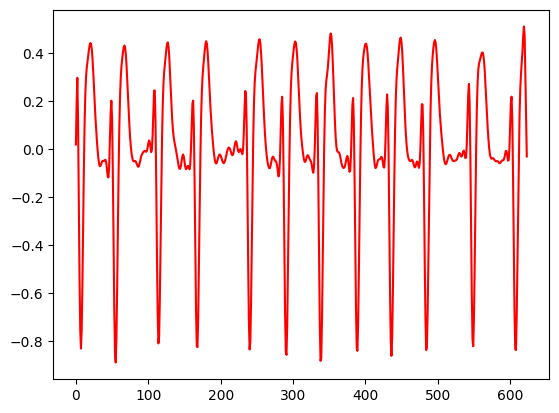

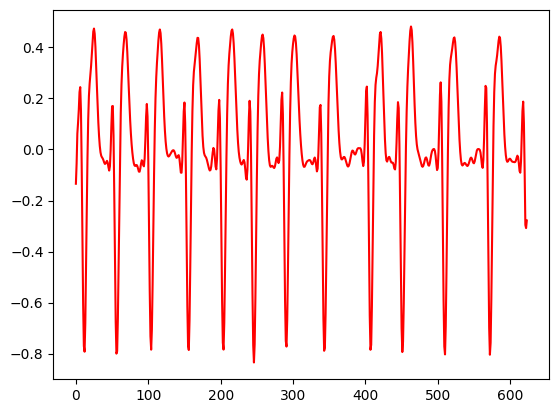

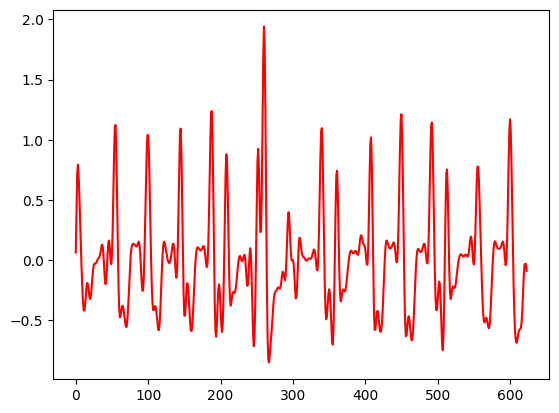

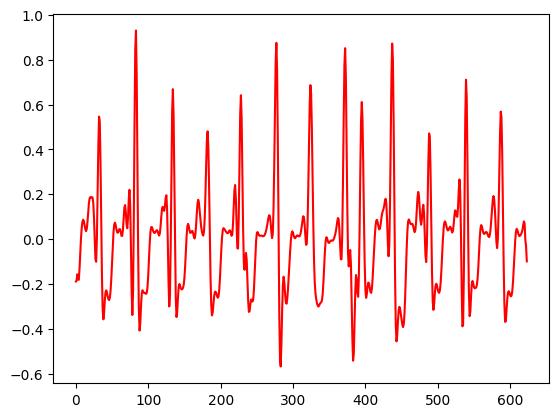

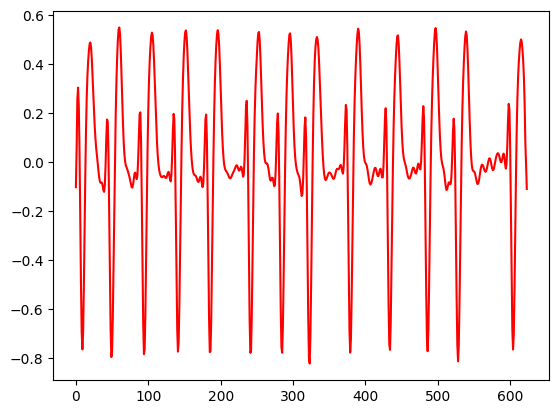

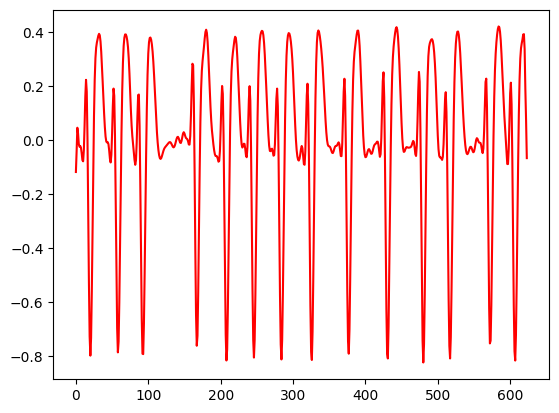

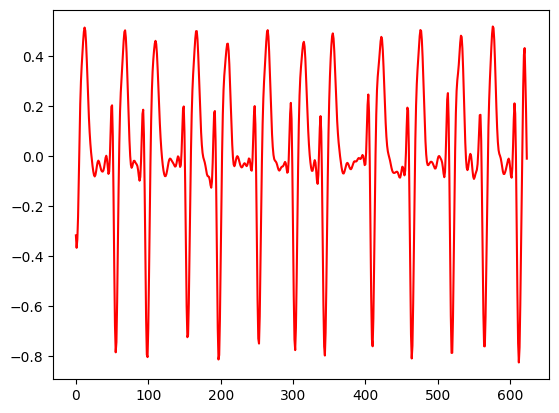

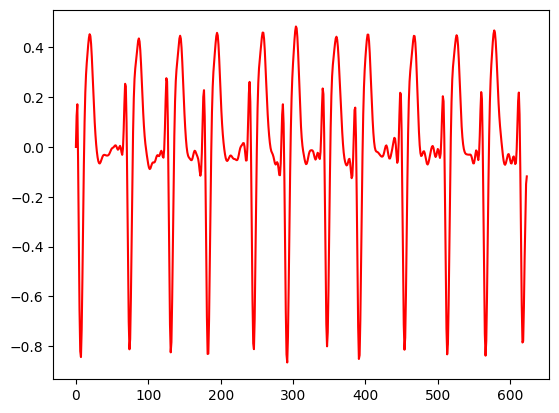

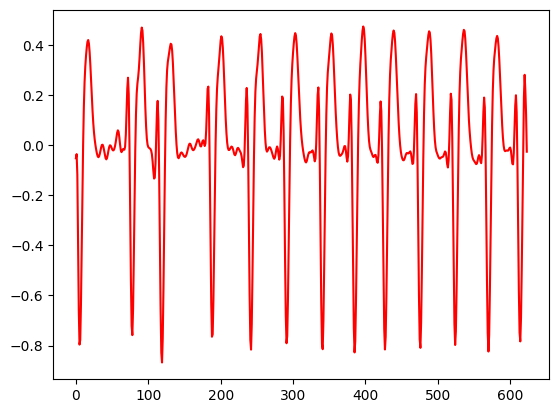

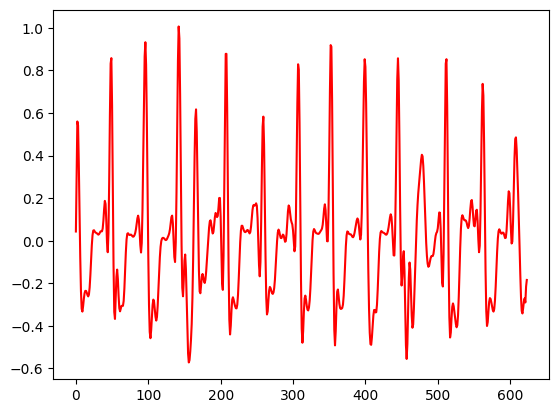

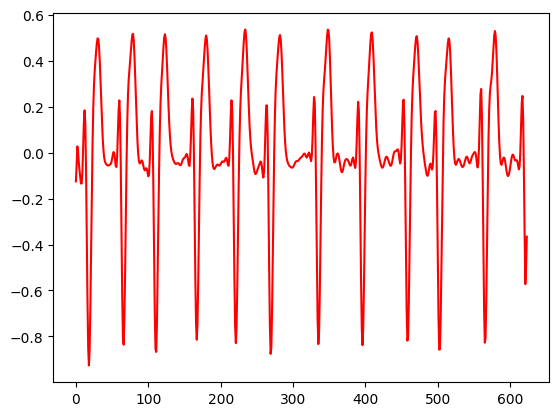

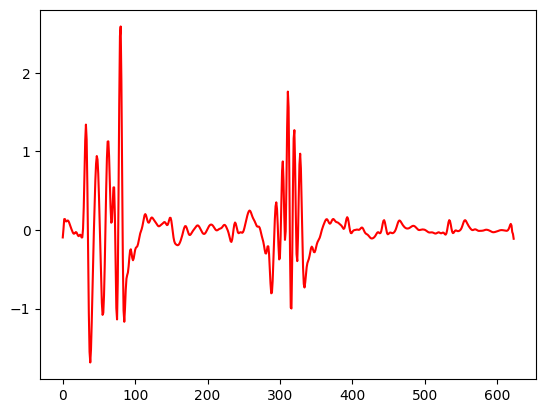

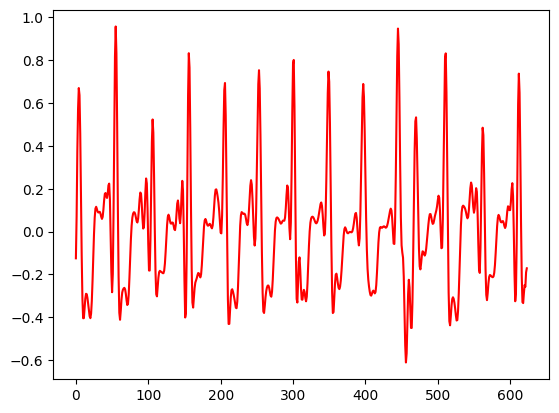

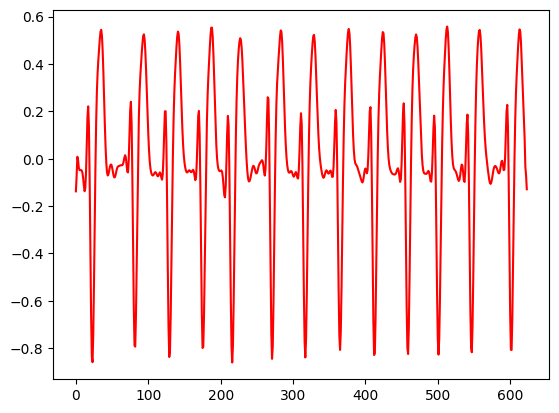

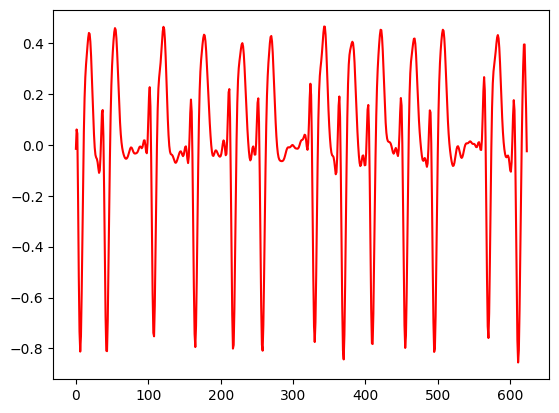

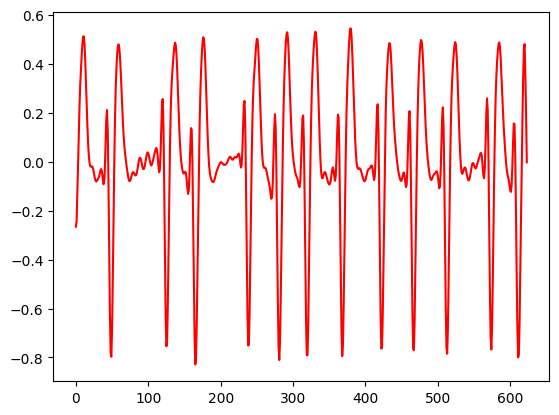

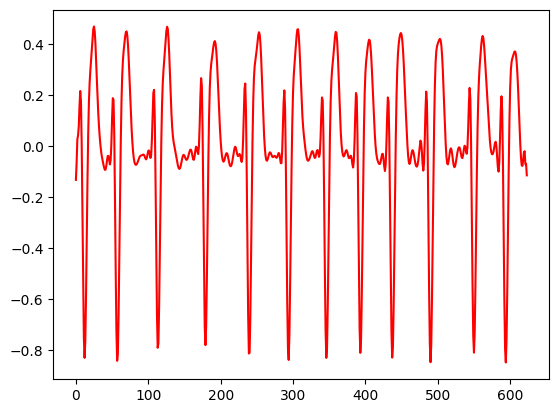

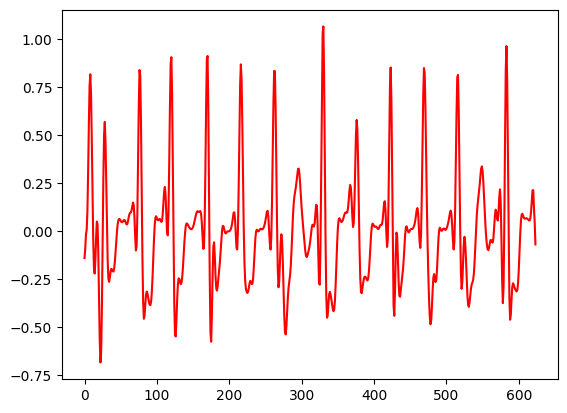

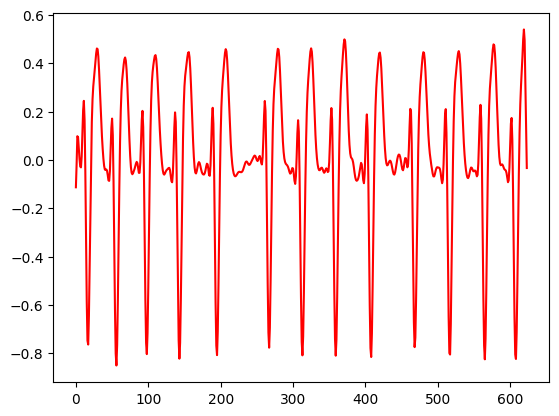

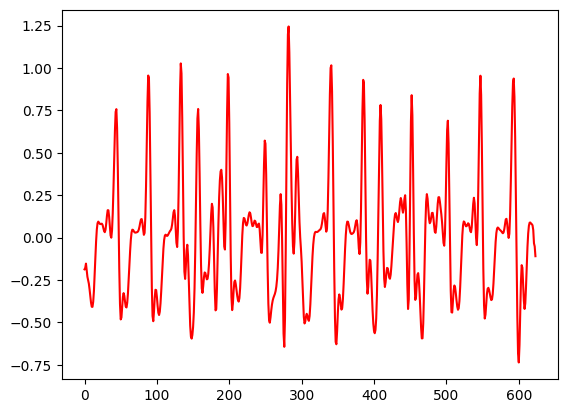

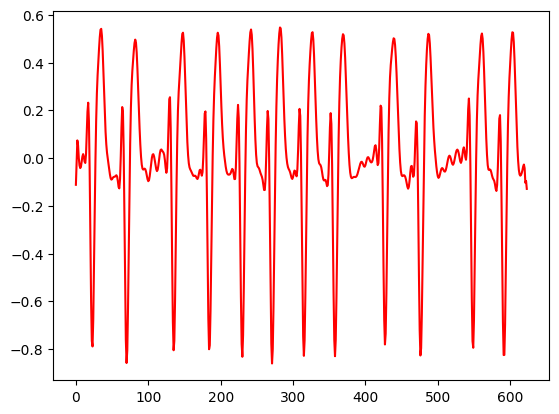

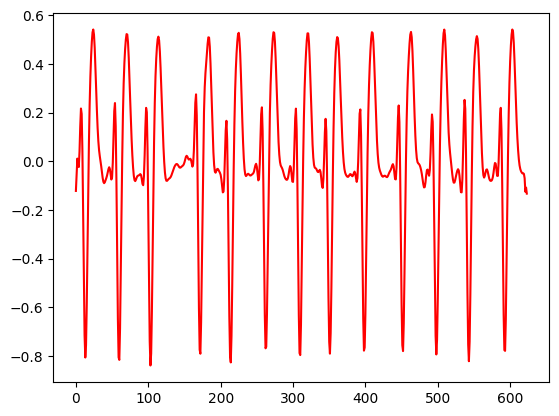

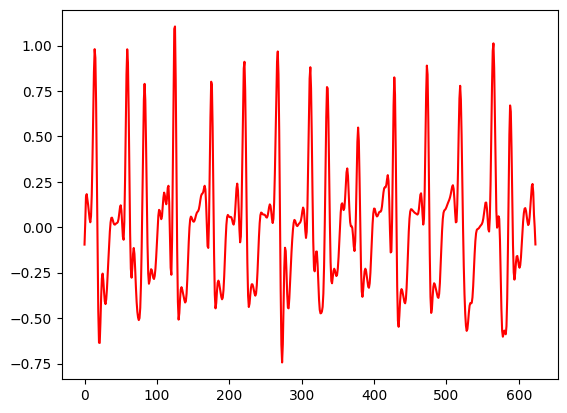

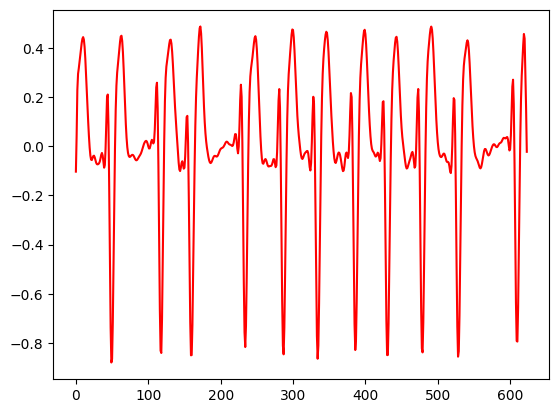

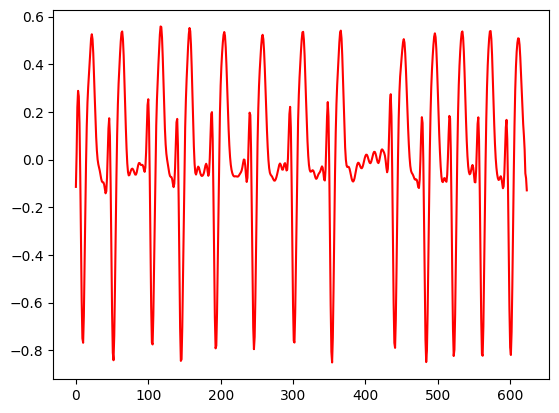

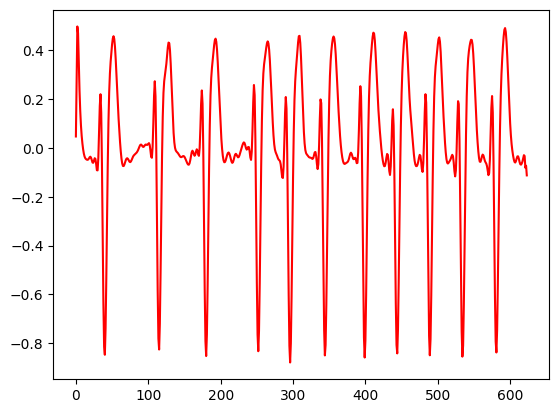

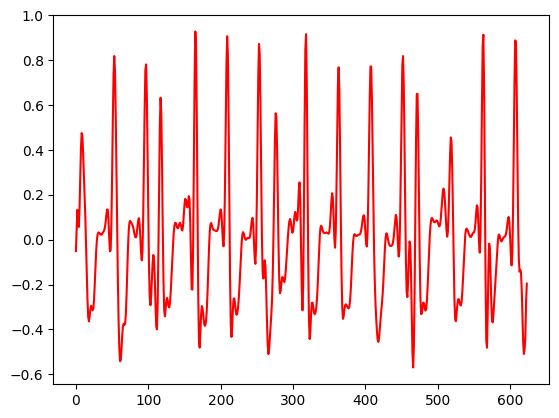

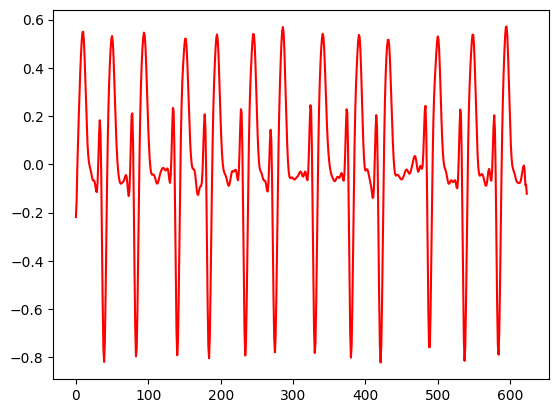

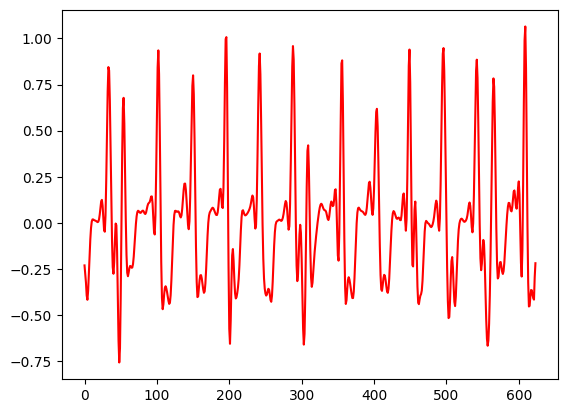

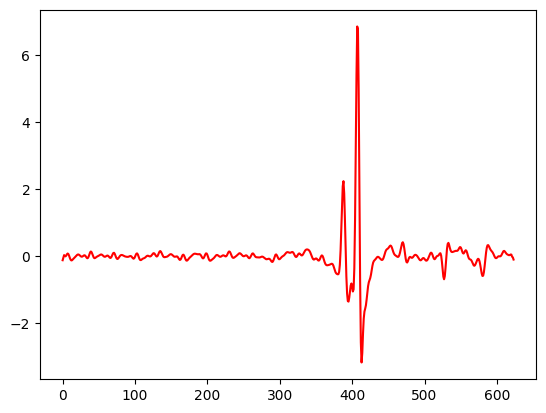

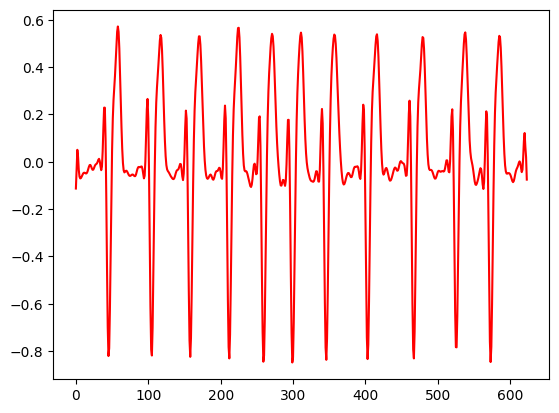

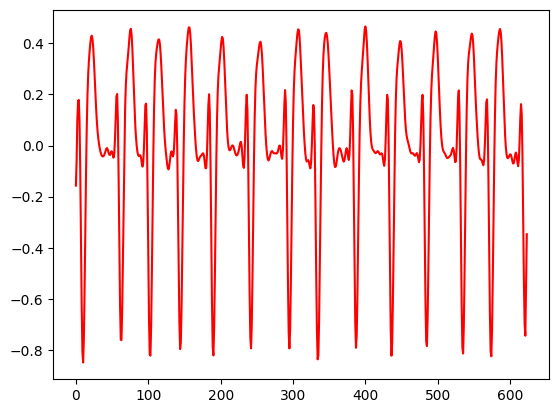

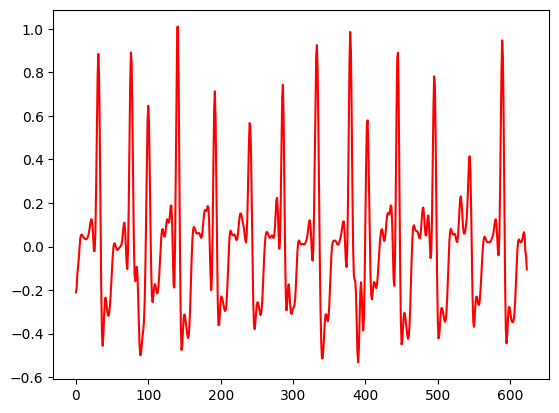

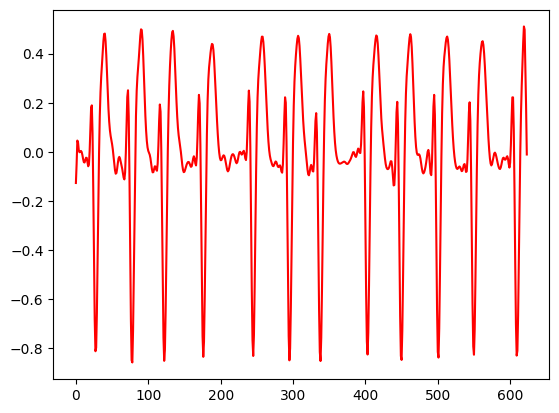

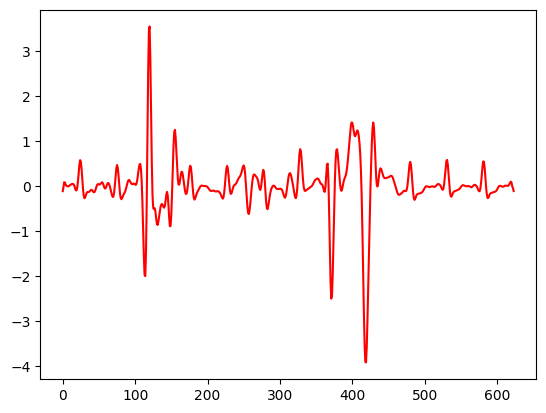

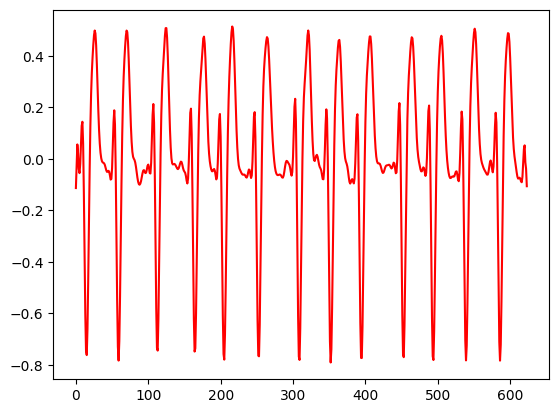

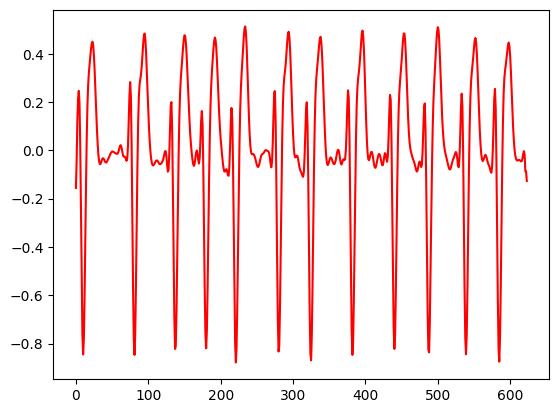

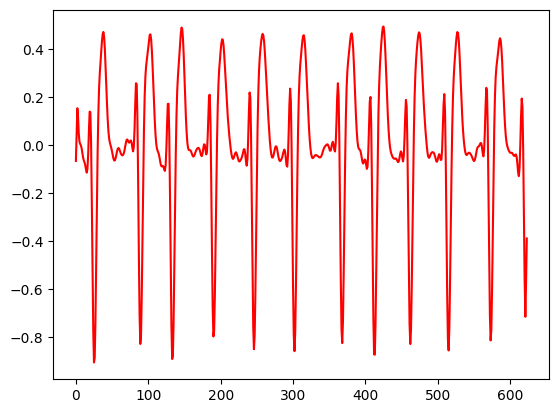

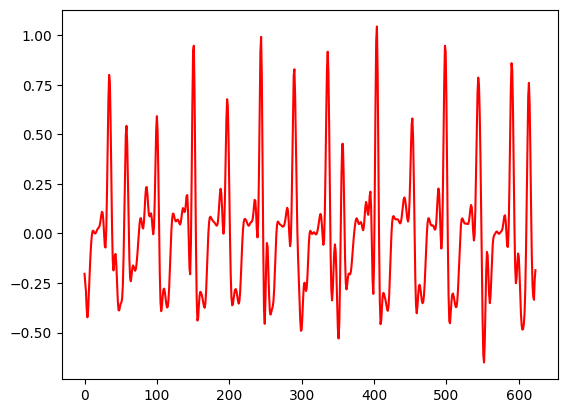

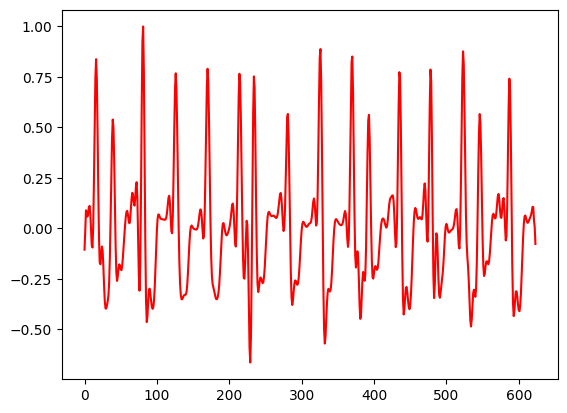

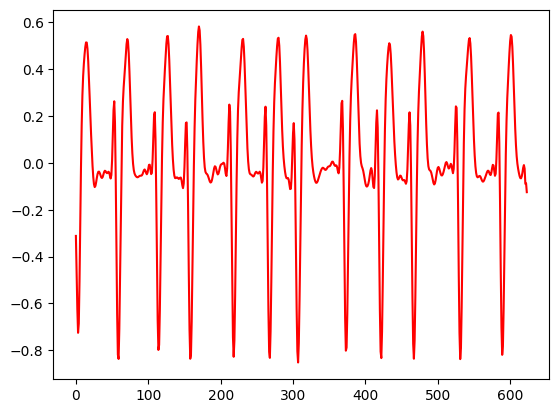

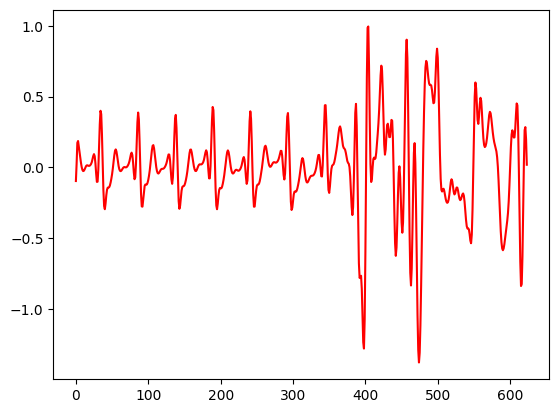

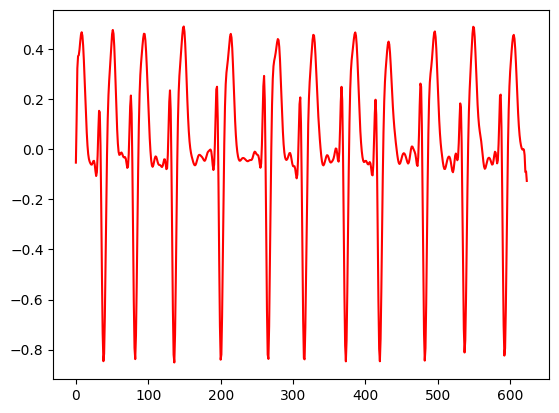

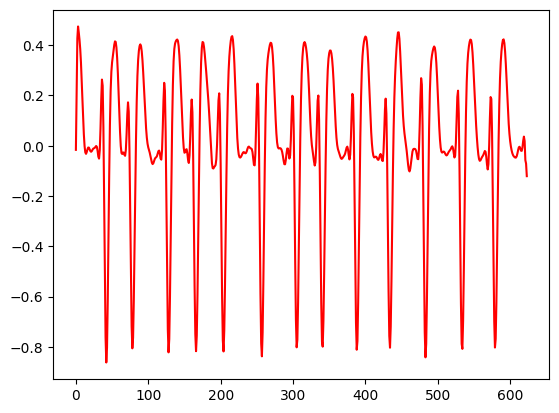

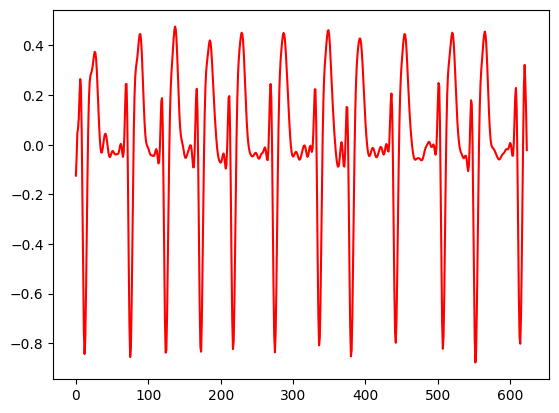

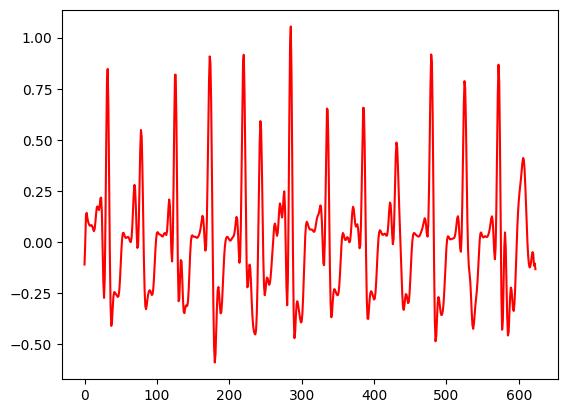

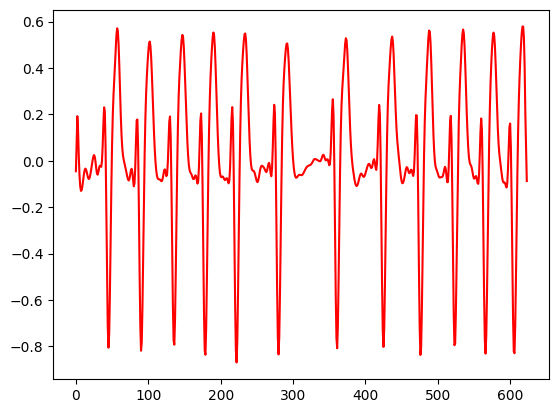

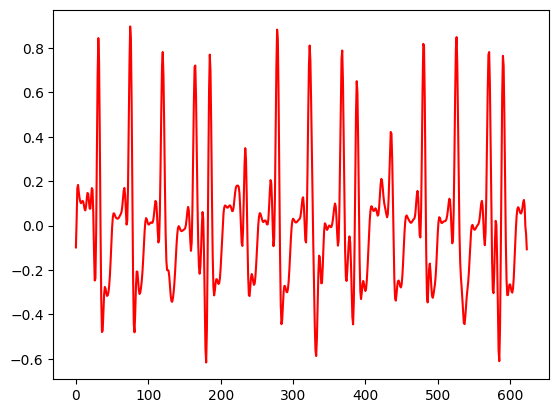

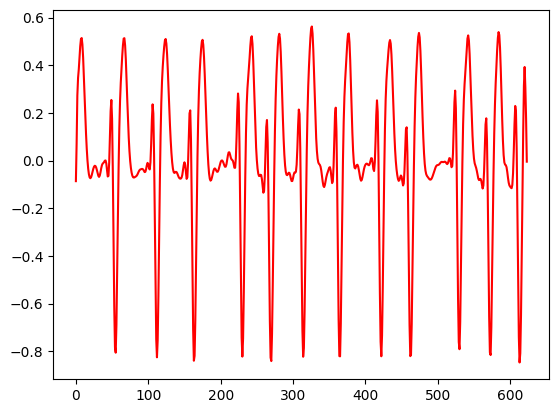

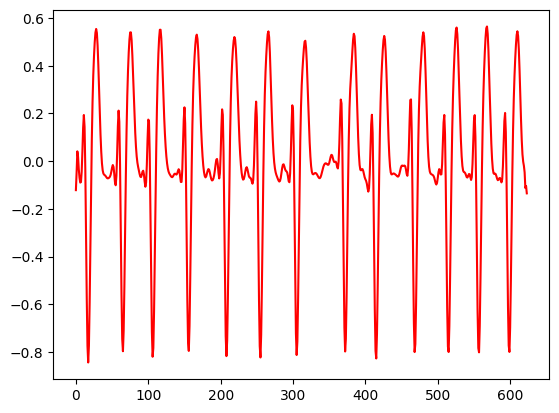

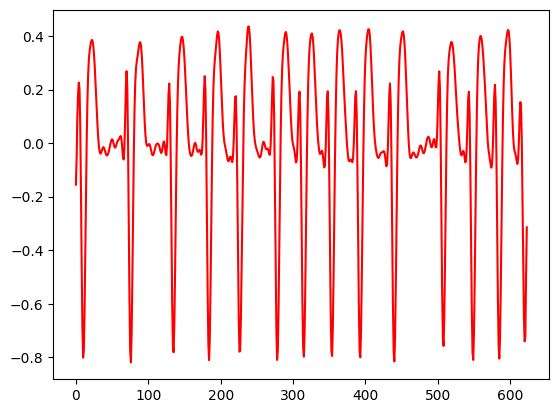

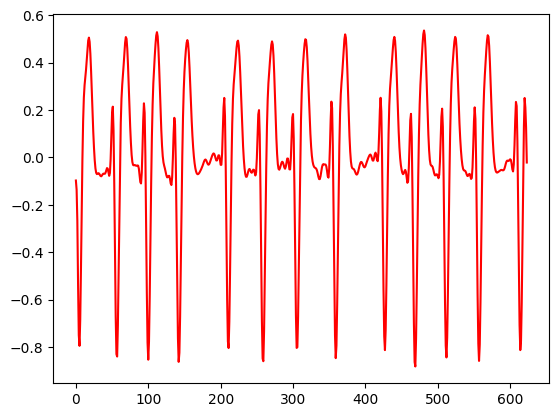

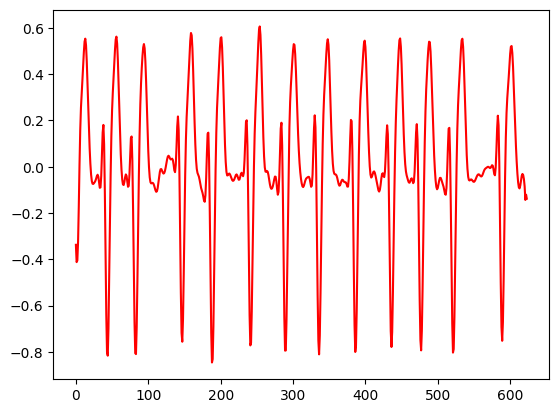

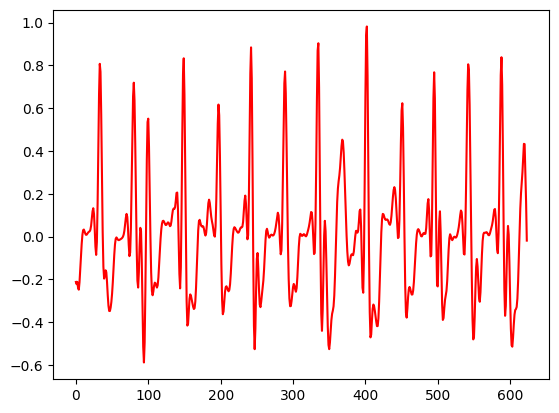

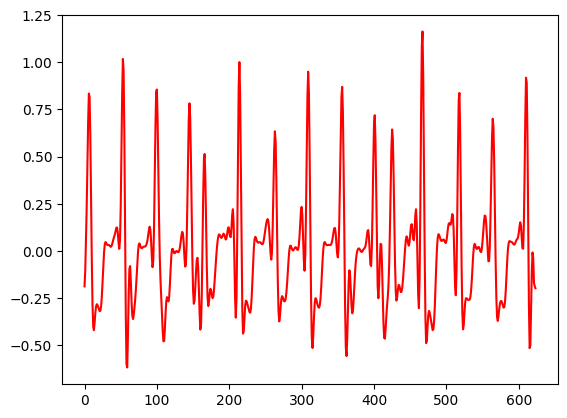

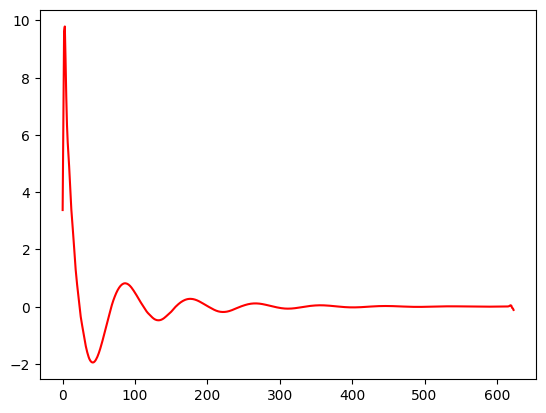

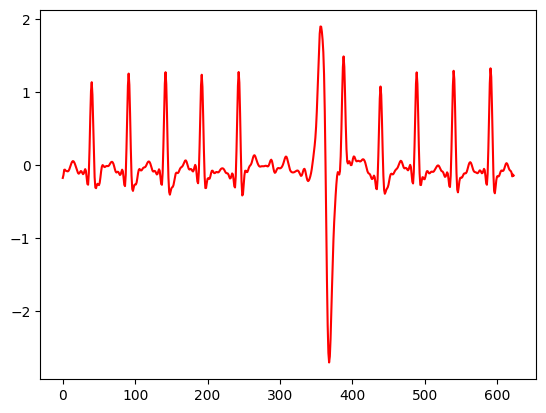

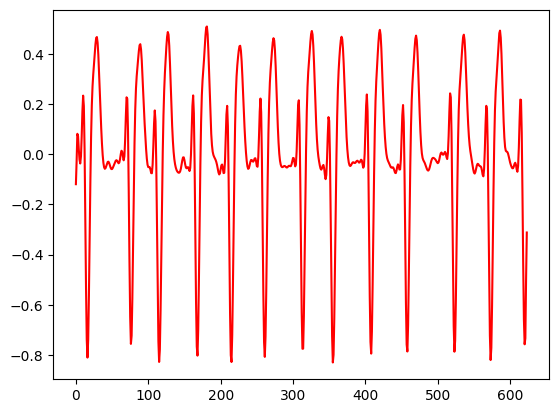

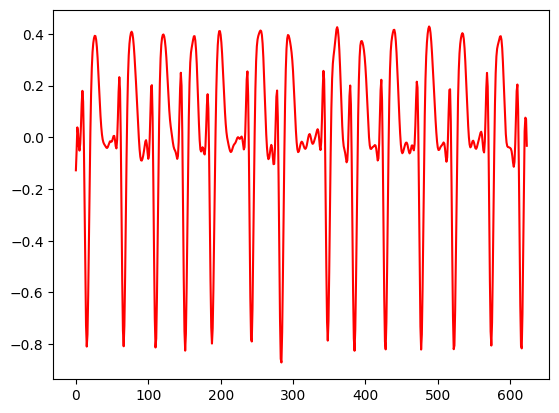

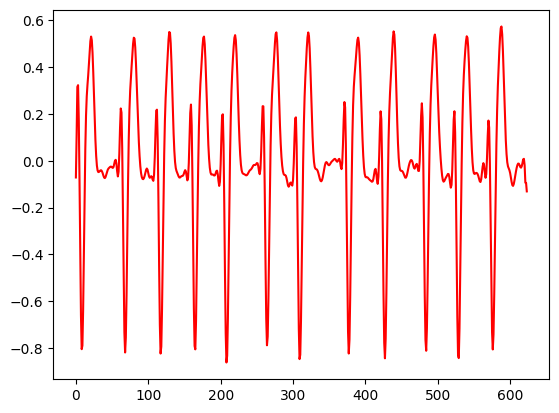

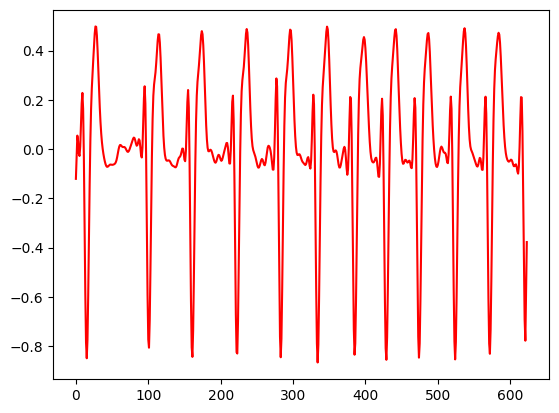

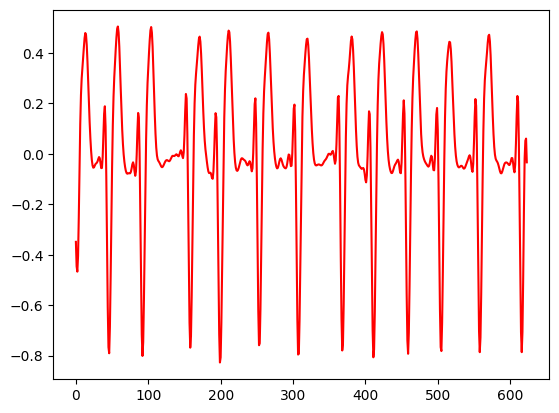

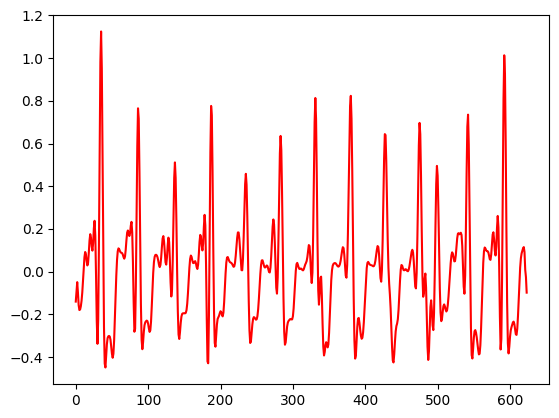

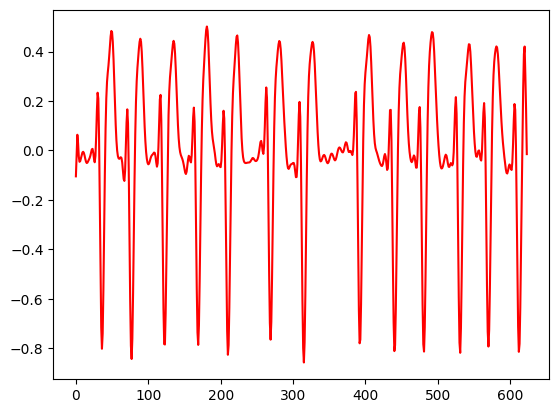

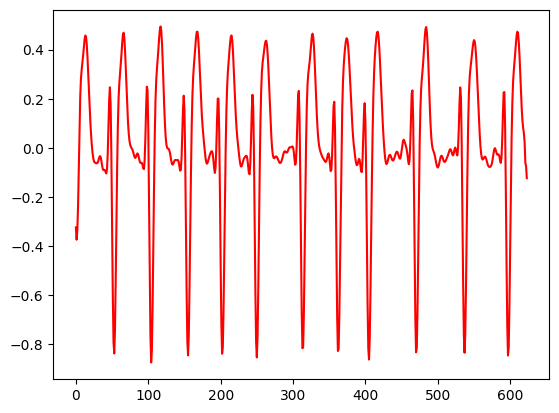

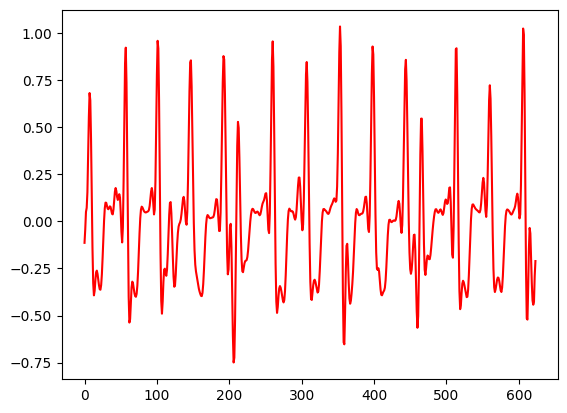

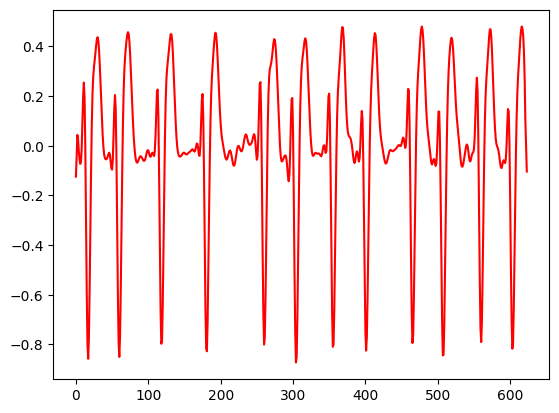

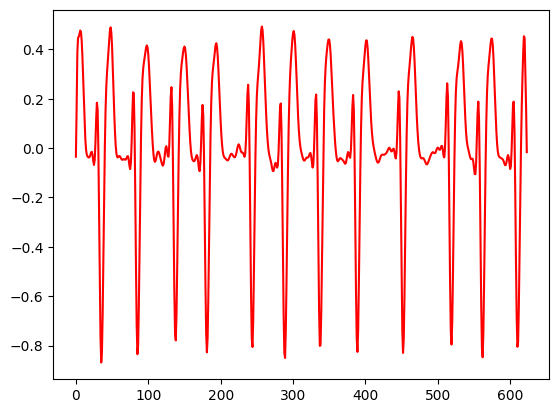

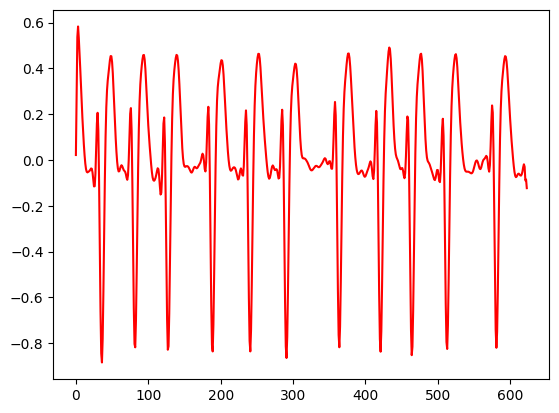

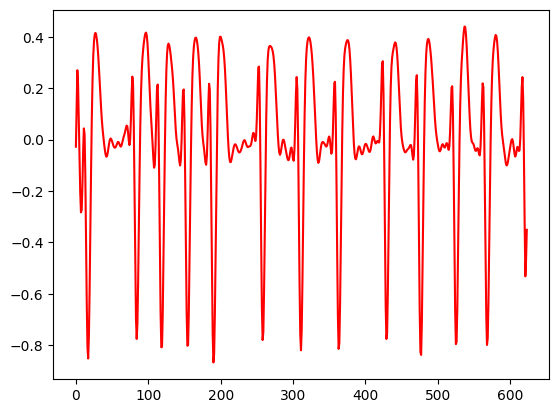

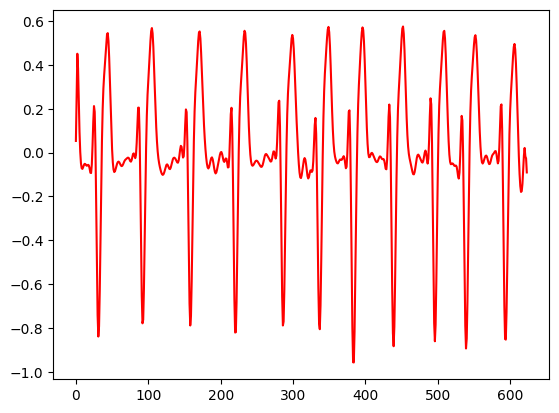

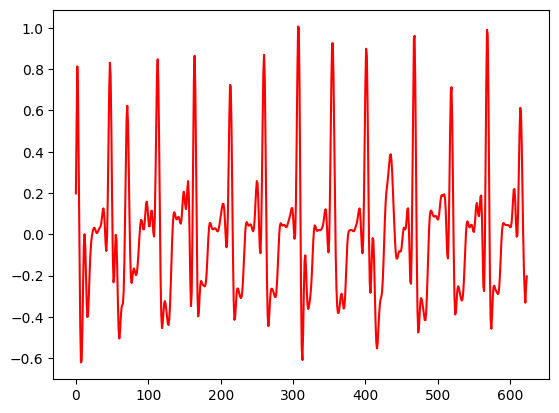

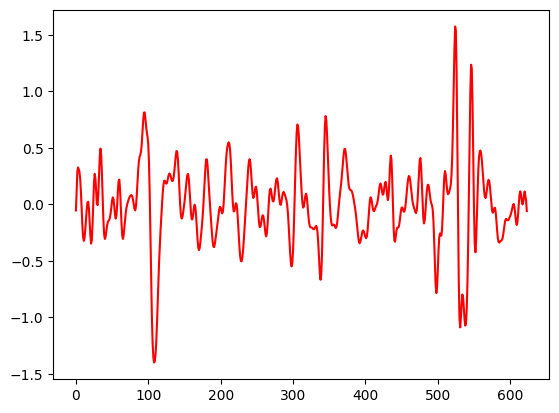

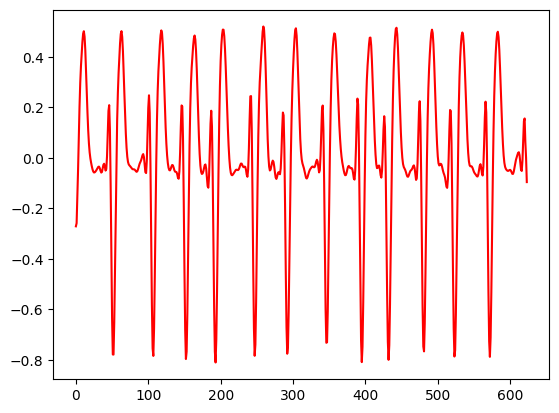

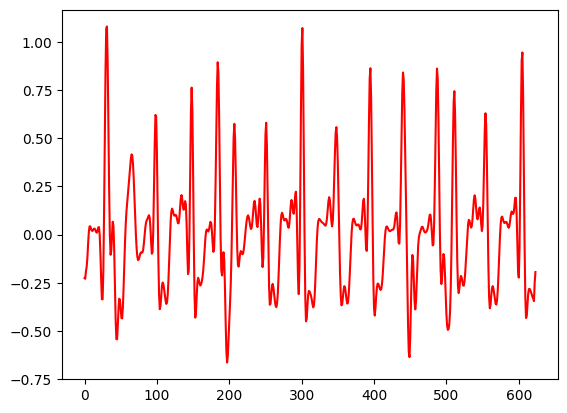

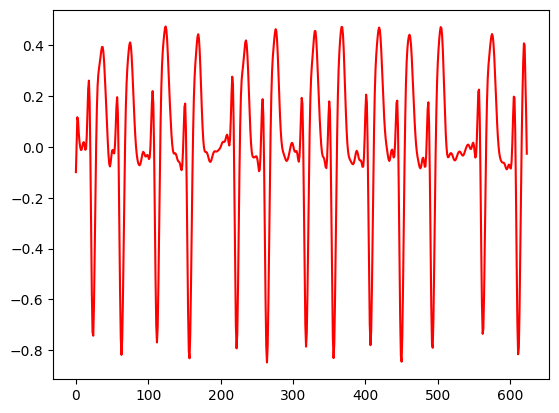

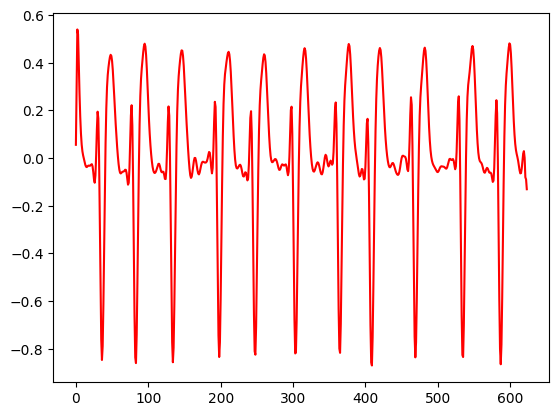

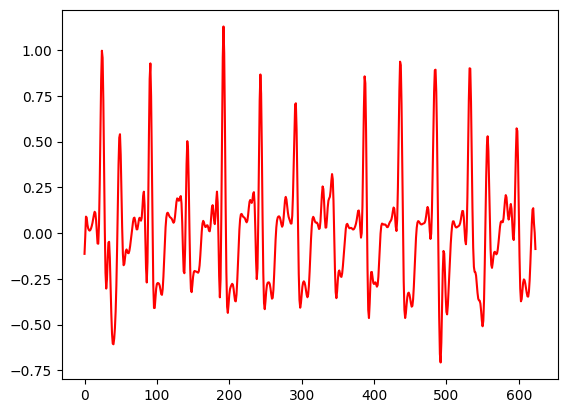

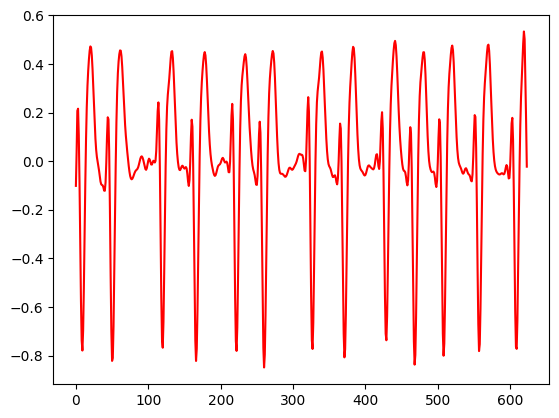

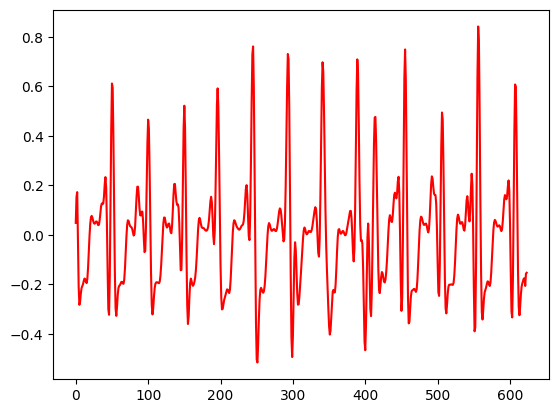

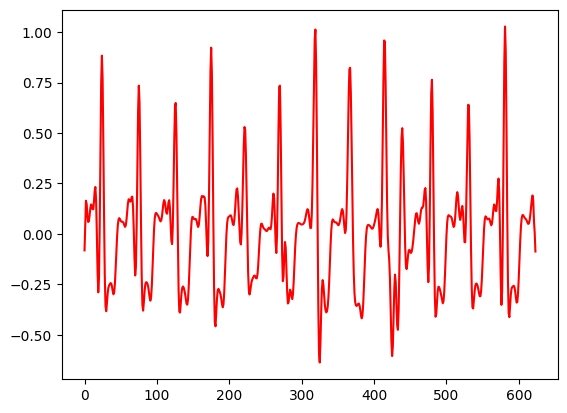

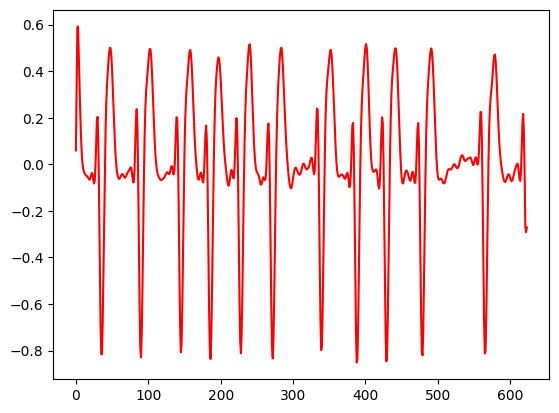

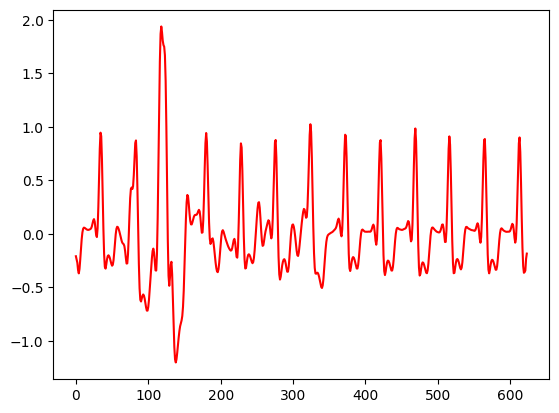

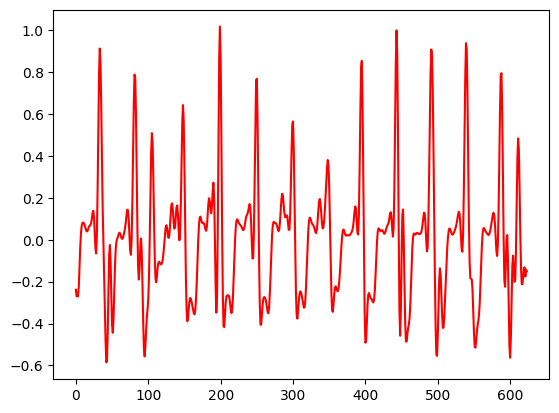

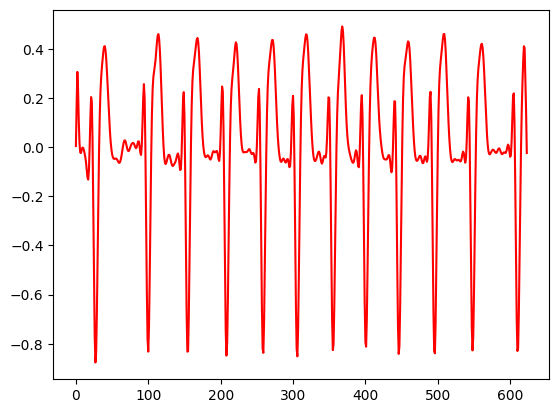

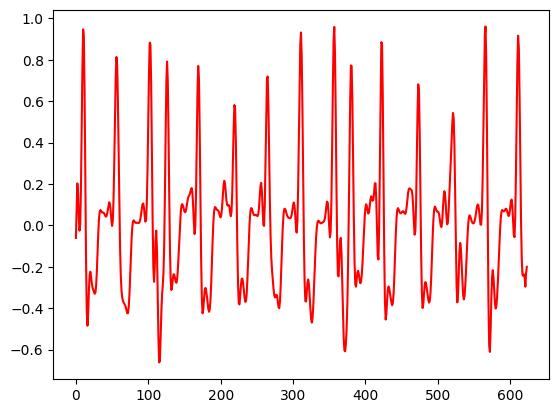

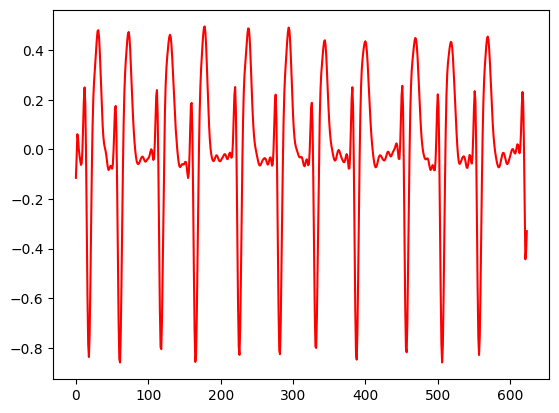

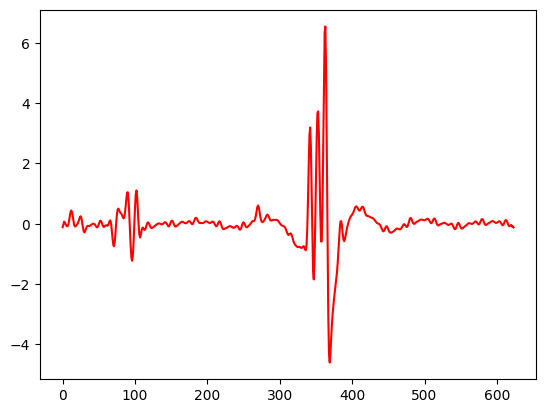

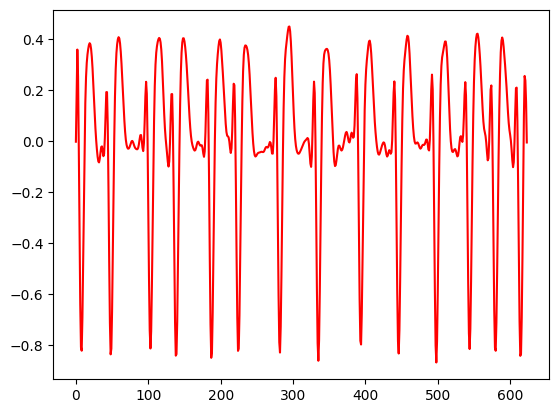

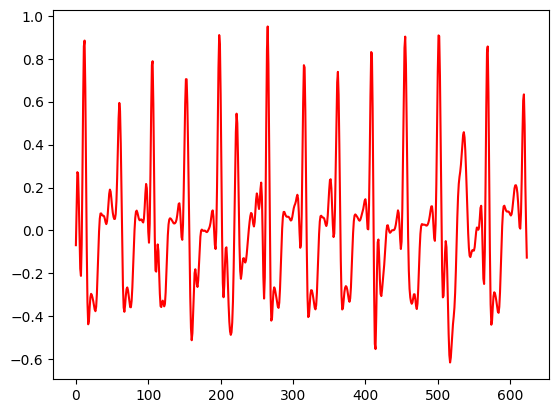

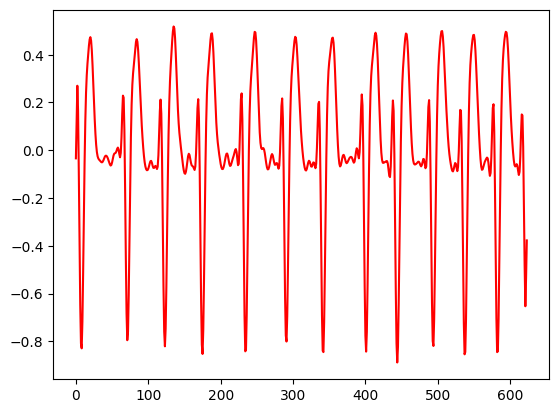

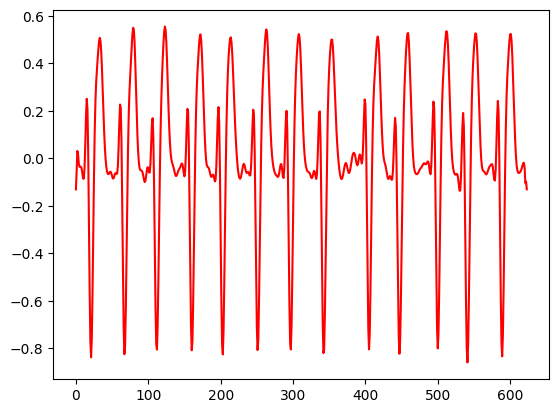

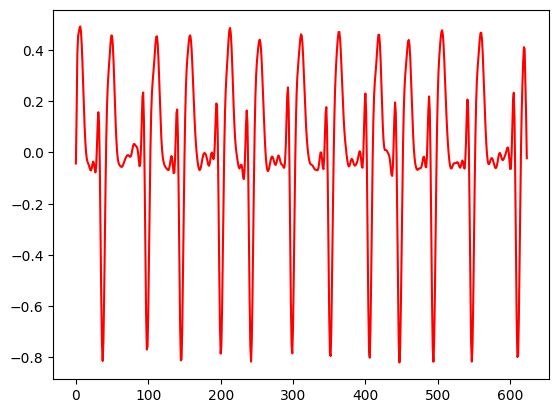

<Figure size 640x480 with 0 Axes>

In [46]:
# Detect all the samples which are anomalies.
anomalies = []
for i in range(len(x_test_pred)):
    if test_mae_loss[i] > 0.05 and test_mae_loss[i] <0.08:
        anomalies.append(True)
    else: anomalies.append(False)

num_anomalies = len(list(np.where(anomalies)[0]))

#patient_num = 1
for i in range(num_anomalies):

    # Checking how the first sequence is learnt
    plt.plot(x_test_pred[list(np.where(anomalies)[0])[i]], color="red")
    plt.show()
    plt.savefig('anomalies_lstm/'+str(i)+'.png')